Importing all the Libraries

In [13]:
from tqdm import tqdm
tqdm.pandas()
from ipywidgets import interact
import unidecode
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import re
#https://pypi.org/project/tqdm/ information on tqdm
from tqdm import tqdm
tqdm.pandas()

#Data Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Data Modeling
from sklearn.feature_extraction.text import  TfidfVectorizer
from sklearn.model_selection import  train_test_split
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from nltk.stem import WordNetLemmatizer
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
df=pd.read_json("train.json")
df.head(5)

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."


In [3]:
print('Shape',df.shape)

Shape (39774, 3)


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           39774 non-null  int64 
 1   cuisine      39774 non-null  object
 2   ingredients  39774 non-null  object
dtypes: int64(1), object(2)
memory usage: 932.3+ KB


In [7]:
print('Total cuisines with there value count')
df.cuisine.value_counts()

Total cuisines with there value count


cuisine
italian         7838
mexican         6438
southern_us     4320
indian          3003
chinese         2673
french          2646
cajun_creole    1546
thai            1539
japanese        1423
greek           1175
spanish          989
korean           830
vietnamese       825
moroccan         821
british          804
filipino         755
irish            667
jamaican         526
russian          489
brazilian        467
Name: count, dtype: int64

Checking the number of ingredients for a single cuisine

In [8]:
ingredients_count=[]
for x in range(len(df.id)):
     
     ingredients_count.append(len(df.ingredients[x]))
        

In [9]:
df['ingredients_count']=ingredients_count
df.head(5)

,id,cuisine,ingredients,ingredients_count
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes...",9
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g...",11
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g...",12
3,22213,indian,"[water, vegetable oil, wheat, salt]",4
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe...",20


In [11]:
print("Unique value for number of ingridients:")
df.ingredients_count.unique()

Unique value for number of ingridients:


array([ 9, 11, 12,  4, 20, 13, 10,  6, 15, 17, 14,  5, 16,  8,  7, 22,  3,
        2, 18, 24, 38, 21, 40, 23, 19, 25, 26, 27,  1, 34, 28, 30, 29, 32,
       36, 49, 31, 35, 65, 33, 52, 59, 43])

Removing cuisine with ingridients value less than 3 

In [12]:
df=df[df.ingredients_count>=3]

Preprocessing the data

In [14]:
import nltk

nltk.download('wordnet')  # Download required NLTK data (tokenizers, etc.)

sentence = "NLTK is installed and ready to use!"
tokens = nltk.word_tokenize(sentence)

print(tokens)

['NLTK', 'is', 'installed', 'and', 'ready', 'to', 'use', '!']


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/divyanshusrivastava/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [15]:

lemmatizer=WordNetLemmatizer()
def preprocess(ingredietns):
    text=' '.join(ingredietns)
    text=text.lower()
    text=text.replace('-',' ')
    words=[]
    for word in text.split():
        word=re.sub("[0-9]"," ",word)
        word=re.sub((r'\b(oz|ounc|ounce|pound|lb|inch|inches|kg|to)\b'), ' ', word)
        if len(word)<=2: continue
        word=unidecode.unidecode(word)
        word=lemmatizer.lemmatize(word)
        if len(word)>0:words.append(word)
    return ' '.join(words)    

In [16]:
for ingredient, expected in [
    ('Eggs', 'egg'),
    ('all-purpose flour', 'all purpose flour'),
    ('purée', 'puree'),
    ('1% low-fat milk', 'low fat milk'),
    ('half & half', 'half half'),
    ('safetida (powder)', 'safetida (powder)')
]:
    actual = preprocess([ingredient])
    assert actual == expected, f'"{expected}" is excpected but got "{actual}"'

In [17]:
df['preprocessed_ingridents']=df.ingredients.progress_apply(preprocess)
df.head(5)

100%|██████████| 39559/39559 [00:03<00:00, 10998.16it/s]


,id,cuisine,ingredients,ingredients_count,preprocessed_ingridents
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes...",9,romaine lettuce black olive grape tomato garli...
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g...",11,plain flour ground pepper salt tomato ground b...
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g...",12,egg pepper salt mayonaise cooking oil green ch...
3,22213,indian,"[water, vegetable oil, wheat, salt]",4,water vegetable oil wheat salt
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe...",20,black pepper shallot cornflour cayenne pepper ...


In [18]:
vectorizer=TfidfVectorizer(sublinear_tf=True)

In [19]:
cuisine_list={'greek':0, 'southern_us':1, 'filipino':2, 'indian':3, 'jamaican':4,
       'spanish':5, 'italian':6, 'mexican':7, 'chinese':8, 'british':9, 'thai':10,
       'vietnamese':11, 'cajun_creole':12, 'brazilian':13, 'french':14, 'japanese':15,
       'irish':16, 'korean':17, 'moroccan':18, 'russian':19}

In [20]:
cuisine_list=[cuisine_list[label]for label in df.cuisine]
df['label']=cuisine_list

In [25]:
X_train,X_test,y_train,y_test=train_test_split(df.preprocessed_ingridents,df.label,test_size=0.1,random_state=21)

In [26]:
X_train_vec=vectorizer.fit_transform(X_train)
X_test_vec=vectorizer.transform(X_test)

In [27]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((35603,), (3956,), (35603,), (3956,))

In [28]:
X_train_vec[0]

<1x2687 sparse matrix of type '<class 'numpy.float64'>'
	with 15 stored elements in Compressed Sparse Row format>

In [29]:
X_train_vec.sort_indices()

In [30]:
classifier = SVC(C=100, # penalty parameter
	 			 kernel='rbf', # kernel type, rbf working fine here
	 			 degree=3, # default value
	 			 gamma=1, # kernel coefficient
	 			 coef0=1, # change to 1 from default value of 0.0
	 			 shrinking=True, # using shrinking heuristics
	 			 tol=0.001, # stopping criterion tolerance 
	      		 probability=False, # no need to enable probability estimates
	      		 cache_size=200, # 200 MB cache size
	      		 class_weight=None, # all classes are treated equally 
	      		 verbose=False, # print the logs 
	      		 max_iter=-1, # no limit, let it run
          		 decision_function_shape='ovr', # will use one vs rest explicitly 
          		 random_state=None)

In [31]:
model = OneVsRestClassifier(classifier, n_jobs=4)
model.fit(X_train_vec, y_train)

OneVsRestClassifier(estimator=SVC(C=100, coef0=1, gamma=1), n_jobs=4)

In [32]:
y_pred = model.predict(X_test_vec)



In [33]:
y_pred[:5]

array([ 8,  1, 11, 10,  7])

In [34]:
y_test[:5]

10918    11
11079     1
27326    11
31438    10
12762     7
Name: label, dtype: int64

In [35]:
from sklearn.metrics import confusion_matrix,classification_report

In [36]:
cm=confusion_matrix(y_test,y_pred)

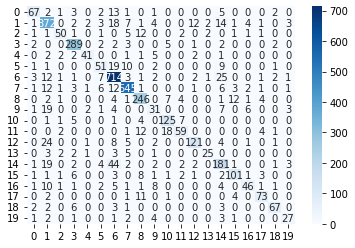

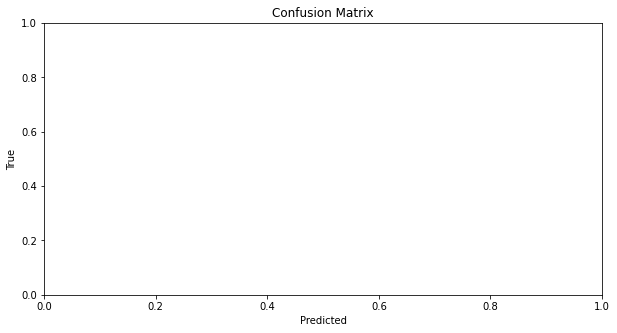

In [50]:
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# Set axis labels and title
plt.figure(figsize=(10,5))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")

# Show the plot
plt.show()

In [48]:
cuisine=['greek', 'southern_us', 'filipino', 'indian', 'jamaican',
              'spanish', 'italian', 'mexican', 'chinese', 'british', 'thai',
              'vietnamese', 'cajun_creole', 'brazilian', 'french', 'japanese',
              'irish', 'korean', 'moroccan', 'russian']

In [49]:
print(classification_report(y_test,y_pred,  target_names=cuisine))

              precision    recall  f1-score   support

       greek       0.81      0.69      0.74        97
 southern_us       0.76      0.83      0.80       447
    filipino       0.79      0.64      0.71        78
      indian       0.89      0.94      0.91       308
    jamaican       0.85      0.72      0.78        57
     spanish       0.65      0.54      0.59        94
     italian       0.84      0.92      0.88       776
     mexican       0.92      0.91      0.92       596
     chinese       0.83      0.87      0.85       283
     british       0.49      0.42      0.45        74
        thai       0.80      0.87      0.83       144
  vietnamese       0.78      0.61      0.68        97
cajun_creole       0.85      0.72      0.78       167
   brazilian       0.83      0.60      0.69        42
      french       0.68      0.69      0.68       264
    japanese       0.81      0.77      0.79       132
       irish       0.74      0.56      0.64        82
      korean       0.82    

In [38]:
import joblib
joblib.dump(model,'cuisine_models.joblib')

['cuisine_models.joblib']

In [39]:
joblib.dump(vectorizer,'cuisine_vectorizers.joblib')

['cuisine_vectorizers.joblib']

In [40]:
import joblib

In [41]:
def detect(model,text):
    text=preprocess(text)
    vc=joblib.load('cuisine_vectorizers.joblib')
    x=vc.transform([text])
    m=model.predict(x)
    print(reversed_dict[m[0]])
model_cuisin=joblib.load('cuisine_models.joblib')  
 
    

In [42]:
message=['romaine lettuce',
 'black olives',
 'grape tomatoes',
 'garlic',
 'pepper',
 'purple onion',
 'seasoning',
 'garbanzo beans',
 'feta cheese crumbles']


In [43]:
y={'greek':0, 'southern_us':1, 'filipino':2, 'indian':3, 'jamaican':4,
       'spanish':5, 'italian':6, 'mexican':7, 'chinese':8, 'british':9, 'thai':10,
       'vietnamese':11, 'cajun_creole':12, 'brazilian':13, 'french':14, 'japanese':15,
       'irish':16, 'korean':17, 'moroccan':18, 'russian':19}
# Reverse the dictionary
reversed_dict = {value: key for key, value in y.items()}

# Print the reversed dictionary
print(reversed_dict)

{0: 'greek', 1: 'southern_us', 2: 'filipino', 3: 'indian', 4: 'jamaican', 5: 'spanish', 6: 'italian', 7: 'mexican', 8: 'chinese', 9: 'british', 10: 'thai', 11: 'vietnamese', 12: 'cajun_creole', 13: 'brazilian', 14: 'french', 15: 'japanese', 16: 'irish', 17: 'korean', 18: 'moroccan', 19: 'russian'}


In [44]:
detect(model_cuisin,message)

greek
